<a href="https://colab.research.google.com/github/SiriosMEN/Data-science/blob/main/price_prediction/autoprice_predict_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor,CatBoostClassifier,CatBoost
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

Загрузим данные датасета:

In [ ]:
data = pd.read_csv('/datasets/autos.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data = data.drop_duplicates()

Признак 'PostalCode' является признаком региона, однако он представлен целочисленными данными. Для корректности отнесем его также к категориальным признакам.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
Проверим какие значения принимает признак PostalCode
</div>

In [ ]:
len(data['PostalCode'].unique())

8143

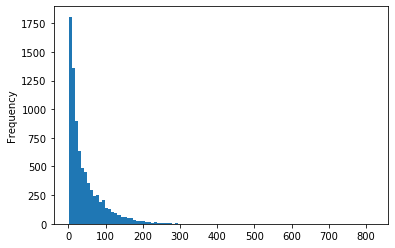

In [ ]:
data['PostalCode'].value_counts().plot(kind='hist',bins=100)

Признак принимает 8143 уникальных значений, из них подавляющее большинство встречается по нескольку раз. Возможно, если бы у нас был доступ к значениям этих почтовых кодов для того, чтобы объединить их по большим регионам, такой признак был бы важен при обучении моделей. В нашем случае удалим данный признак.

In [ ]:
data=data.drop(['PostalCode'],axis='columns')

Признаки с датами вряд ли влияют на предсказание стоимости автомобиля, дата создания анкеты, дата скачивания анкеты из базы и дата последней активности могут быть удалены:

In [ ]:
data=data.drop(['DateCrawled','DateCreated','LastSeen'],axis='columns')

Колонка с количеством фотографий вызывает некоторые сомнения, проверим ее содержание:

In [ ]:
data['NumberOfPictures'].describe()

count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Признак содержит только нулевые значения. Данный признак также должен быть удален, поскольку модель, обученная на нулевых значениях не сможет сделать корректное предсказание с учетом данного признака:

In [ ]:
data = data.drop(['NumberOfPictures'],axis='columns')

In [ ]:
data = data.fillna(value='NotDef')

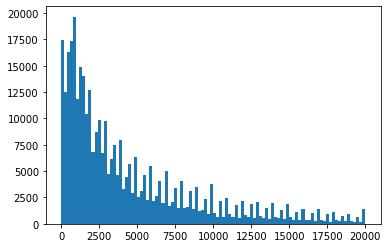

In [ ]:
plt.hist(data['Price'],bins=100);

Целевой признак цены принимает нулевое значение, что нелогично. Проверим сколько таких строк:

In [ ]:
data.query('Price==0').count()

Price                10772
VehicleType          10772
RegistrationYear     10772
Gearbox              10772
Power                10772
Model                10772
Kilometer            10772
RegistrationMonth    10772
FuelType             10772
Brand                10772
NotRepaired          10772
dtype: int64

Довольно много таких строк. Заменять нулевые значения целевого признака какими-то средними или медианными значениями на мой взгляд некорректно, это приведет к ухудшению обучения моделей. Удалим строки с околонулевыми значениями цены:

In [ ]:
data.query('Price>10',inplace=True)

Проверим, есть ли аномальные значения года выпуска:

In [ ]:
data.query('1900<RegistrationYear>2021').count()

Price                82
VehicleType          82
RegistrationYear     82
Gearbox              82
Power                82
Model                82
Kilometer            82
RegistrationMonth    82
FuelType             82
Brand                82
NotRepaired          82
dtype: int64

Удалим некорректные значения:

In [ ]:
data.query('2021>RegistrationYear>1900',inplace=True)

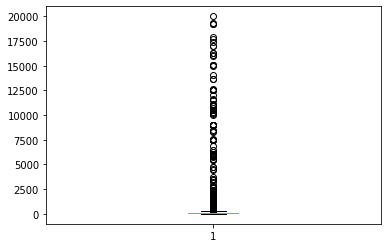

In [ ]:
plt.boxplot(data['Power']);

Имеется значительное количество выбросов в некорректных значениях. Удалим явно некорректные значения:

In [ ]:
data.query('0<Power<1000',inplace=True)

Проверим значения признака 'Kilometer':

In [ ]:
data['Kilometer'].describe()

count    306163.000000
mean     128417.819919
std       36716.317489
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Похоже, что выбросы отсутствуют.

Проверим признак 'RegistrationMonth':

In [ ]:
data['RegistrationMonth'].value_counts()

3     31308
6     28420
4     26565
5     26355
7     24541
10    23593
12    21869
11    21689
9     21515
1     20754
8     20323
0     19855
2     19376
Name: RegistrationMonth, dtype: int64

Выбросы отсутствуют, но есть ряд строк с нулевым значением. Думаю для предсказаний это не окажет значительного влияния.

Составим список категориальных признаков:

In [ ]:
cat_features = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']

Проверим категориальные признаки:

In [ ]:
for i in range(len(cat_features)):
    print(cat_features[i],data[cat_features[i]].unique())

VehicleType ['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'NotDef'
 'other']
Gearbox ['manual' 'auto' 'NotDef']
Model ['NotDef' 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'other' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'one' 'fortwo' '1er' 'b_klasse' 'a8' 'jetta' 'astra' 'fiesta'
 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort' 'forester' 'xc_reihe'
 'scenic' 'ka' 'a1' 'focus' 'a4' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er'
 'combo' 'corsa' '80' '147' 'z_reihe' 'sportage' 'sorento' 'ibiza'
 'mustang' 'eos' 'touran' 'getz' 'insignia' 'almera' 'megane' 'a3' 'lupo'
 'r19' 'caddy' 'mondeo' 'cordoba' 'colt' 'impreza' 'vectra' 'berlingo'
 'tiguan' 'i_reihe' '6_reihe' 'panda' 'up' 'ceed' 'kangoo' '5_reihe'
 'yeti' 'octavia' 'zafira' 'mii' 'rx_reihe' '6er' 'modus' 'fox' 'matiz'
 'beetle' 'rio' 'touareg' 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy'
 'c3' 'viano' 's_

Некорректные значения не наблюдаются.

Проверим корреляцию признаков:

In [ ]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.421823,0.499836,-0.385948,0.071134
RegistrationYear,0.421823,1.000000,0.108627,-0.253019,0.026711
Power,0.499836,0.108627,1.000000,0.101861,0.043542
Kilometer,-0.385948,-0.253019,0.101861,1.000000,-0.015560
RegistrationMonth,0.071134,0.026711,0.043542,-0.015560,1.000000


Сильной корреляции не наблюдается. Относительно высокая корреляция наблюдается между годом регистрации, мощностью, пробегом.

Разделим данные на обучающий набор и целевой признак:

In [ ]:
data.reset_index(inplace=True,drop=True)
target = data['Price']
features = data.drop(['Price'],axis='columns')
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.25,random_state=1234)

## Обучение моделей

Создадим и обучим модель с использованием catBoost:

Для начала подберем наиболее оптимальные параметры модели:

In [ ]:
# %%time
# model_catboost = CatBoostRegressor(loss_function='RMSE',cat_features=cat_features,iterations=100)
# grid = {'learning_rate':[0.1,0.3,0.5,0.75],'depth':range(8,17)}
# grid_results = model_catboost.grid_search(grid,X=features,y=target,cv=5,verbose=25,plot=True)

In [ ]:
# print(grid_results['params'])
# print(model_catboost.get_best_score())

Наиболее оптимальные параметры обучения - глубина 13, скорость обучения - 0.3

Напишем функцию для применения на нескольких других алгоритмах:

In [ ]:
def modeling(model,model_type,features_test,target_test,**kwargs):
    start = time.time()
    model=model
    model.fit(**kwargs)
    point1 = time.time()
    predicts = model.predict(features_test)
    end = time.time()
    RMSE = (mean_squared_error(target_test,predicts)**0.5)
    print('RMSE на алгоритме',model_type,'=',RMSE)
    return RMSE, point1-start,end-point1

Проверим время работы на алгоритме CatBoost с заранее подобранными параметрами:

In [ ]:
%%time
RMSE_CB,time_fit_CB,time_predict_CB = modeling(CatBoostRegressor(loss_function='RMSE',cat_features=cat_features,iterations=100,depth=13,learning_rate=0.3,verbose=0),'CatBoost',features_test,target_test,X=features_train,y=target_train)

RMSE на алгоритме CatBoost = 1590.0344581597617
CPU times: user 1min 24s, sys: 9.14 s, total: 1min 33s
Wall time: 1min 35s


Для других алгоритмов закодируем строковые признаки:

In [ ]:
%%time
encoder = OrdinalEncoder()
encoder.fit(features[cat_features])
features_ordinal = features.copy()
features_ordinal[cat_features] = pd.DataFrame(encoder.transform(features[cat_features]),columns=features[cat_features].columns)
features_train_OE,features_test_OE,target_train_OE,target_test_OE = train_test_split(features_ordinal,target,test_size=0.25,random_state=1234)

CPU times: user 685 ms, sys: 41.4 ms, total: 726 ms
Wall time: 728 ms


In [ ]:
features_OHE = pd.get_dummies(features,drop_first=True)
features_train_OHE,features_test_OHE,target_train_OHE,target_test_OHE = train_test_split(features_OHE,target,test_size=0.25,random_state=1234)

In [ ]:
del features

Проверим модель на алгоритме линейной регрессии:

In [ ]:
%%time
RMSE_LR,time_fit_LR,time_predict_LR = modeling(LinearRegression(normalize=True,n_jobs=-1),'линейная регрессия',features_test_OHE,target_test_OHE,X=features_train_OHE,y=target_train_OHE)

RMSE на алгоритме линейная регрессия = 2627.645855440456
CPU times: user 19.8 s, sys: 5.32 s, total: 25.1 s
Wall time: 25.1 s


Проверим модель на алгоритме случайного леса:

In [ ]:
%%time
RMSE_RFR,time_fit_RFR,time_predict_RFR = modeling(RandomForestRegressor(random_state=12345,n_estimators=100,max_depth=20,n_jobs=-1),'случайный лес',features_test_OE,target_test_OE,X=features_train_OE,y=target_train_OE)

RMSE на алгоритме случайный лес = 1586.6334305073594
CPU times: user 1min 21s, sys: 133 ms, total: 1min 22s
Wall time: 1min 22s


Проверим время работы алгоритма LGBM с заранее подобранными параметрами:

In [ ]:
%%time
RMSE_LGBM,time_fit_LGBM,time_predict_LGBM = modeling(LGBMRegressor(learning_rate=0.3,random_state=12345),'LightGBM',features_test_OE,target_test_OE,X=features_train_OE,y=target_train_OE,categorical_feature=cat_features)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RMSE на алгоритме LightGBM = 1606.0377575386556
CPU times: user 7.38 s, sys: 23.9 ms, total: 7.41 s
Wall time: 7.47 s


## Анализ моделей

Соберем воедино все показатели разных моделей:

Проведем анализ полученных результатов обучения моделей:

In [ ]:
results = pd.DataFrame({'Название алгоритма':['CatBoost','Linear Regression','Random Forest Regressor','Ligth Gradient Boost Machine'],'RMSE':[RMSE_CB,RMSE_LR,RMSE_RFR,RMSE_LGBM],'Время обучения':[time_fit_CB,time_fit_LR,time_fit_RFR,time_fit_LGBM],'Время предсказания':[time_predict_CB,time_predict_LR,time_predict_RFR,time_predict_LGBM]})
results

,Название алгоритма,RMSE,Время обучения,Время предсказания
0,CatBoost,1590.034458,95.254045,0.274886
1,Linear Regression,2627.645855,24.763755,0.297887
2,Random Forest Regressor,1586.633431,79.094154,3.013397
3,Ligth Gradient Boost Machine,1606.037758,6.680645,0.710319


Наиболее точный алгоритм - Случайный лес
Наиболее быстрый алгоритм - Линейная регрессия.
Оптимальный алгоритм - "LigthGradientBoostMachine"

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей